In [2]:
!pip install emukit 

     |████████████████████████████████| 241 kB 5.1 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
     |████████████████████████████████| 959 kB 53.7 MB/s 
     |████████████████████████████████| 71 kB 8.3 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565103 sha256=3cd582c9ffbf118971015443686f897f3c51e2ea6e27d66eb909cd2781cd1dd7
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=23bbe1cd78b14498f33cd9027f05a1be8f7fb274df6343d8ab478af9132005d4
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


**This Part is for the non-linear Multi-fidelity Regression** 

Some reasons to utilize this formulation:
* Nonlinear relationship between fidelities
 






 /usr/local/lib/python3.7/dist-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/100, f = 48.39675066516907
Optimization restart 2/100, f = 48.39675066938049
Optimization restart 3/100, f = 48.3967506748547
Optimization restart 4/100, f = 48.396750670384755
Optimization restart 5/100, f = 48.396750678698936
Optimization restart 6/100, f = 48.39675067636239
Optimization restart 7/100, f = 48.396750675616175
Optimization restart 8/100, f = 48.39675067653913
Optimization restart 9/100, f = 48.396750675085904
Optimization restart 10/100, f = 48.39675067003074
Optimization restart 11/100, f = 48.39675067159952
Optimization restart 12/100, f = 48.39675067294053
Optimization restart 13/100, f = 48.39675067537314
Optimization restart 14/100, f = 48.396750675926455
Optimization restart 15/100, f = 48.39675067854692
Optimization restart 16/100, f = 48.39675067599323
Optimization restart 17/100, f = 48.39675066886335
Optimization restart 18/100, f = 48.39675066622685
Optimization restart 19/100, f = 48.39675067432378
Optimization restart 20/100, f = 48.

 /usr/local/lib/python3.7/dist-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /usr/local/lib/python3.7/dist-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /usr/local/lib/python3.7/dist-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 43/100, f = 41.470896170551406
Optimization restart 44/100, f = 41.711518855030185
Optimization restart 45/100, f = 41.71117241837587
Optimization restart 46/100, f = 41.71117571352029
Optimization restart 47/100, f = 40.49988539617226
Optimization restart 48/100, f = 41.71117327571157
Optimization restart 49/100, f = 41.711173408248705
Optimization restart 50/100, f = 41.71117308979462
Optimization restart 51/100, f = 41.711172524279235
Optimization restart 52/100, f = 41.711172081670654
Optimization restart 53/100, f = 41.71117238754732
Optimization restart 54/100, f = 41.711172137051875
Optimization restart 55/100, f = 41.711676172380116
Optimization restart 56/100, f = 40.499885395924764
Optimization restart 57/100, f = 41.71117217955365
Optimization restart 58/100, f = 41.711174547302235
Optimization restart 59/100, f = 41.71117214031906
Optimization restart 60/100, f = 41.71128189694538
Optimization restart 61/100, f = 41.71117216998694
Optimization restart 6

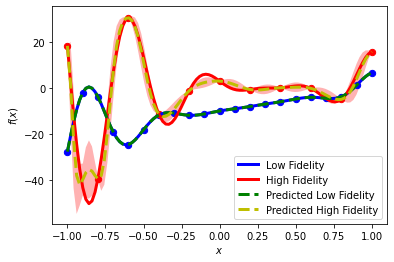

In [ ]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import emukit
from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

np.random.seed(24)
# NOTE the difference for A in fc(x) now it is not a constant value but a value that depends on x 
################################################################################
# Expensive Function
def fe(x):
    return (6.0*x-2.)**2*np.sin(12*x-4)
# Cheap Function
def fc(x):
    A = 0.5*np.sin(x); B=10; C=5
    return A*fe(x) + B*(x-0.5) - C
################################################################################

x  = np.linspace(-1,1,100).reshape(-1,1)                   # Some Uniform Test Points
yl = fc(x)
yh = fe(x)

Xl  =   np.linspace(-1,1,21).reshape(-1,1)                 # Low-fidelity Training Data Feature
Xh  =   np.linspace(-1,1,11).reshape(-1,1)          # High-fidelity Training Data Feature
Yl  =   fc(Xl)                                             # Get Low-fidelity Labels
Yh  =   fe(Xh)                                             # Get High-fidelity Labels

# In emukit you have to structure data in  a certain way that is why you need this extra function
X, Y = convert_xy_lists_to_arrays([Xl, Xh], [Yl, Yh])

# Initialize kernels
base_kernel = GPy.kern.RBF
kernels = make_non_linear_kernels(base_kernel, 2, X.shape[1] - 1)

# Initialize Models
model = NonLinearMultiFidelityModel(X, Y, n_fidelities=2, kernels=kernels, 
                                              verbose=True, optimization_restarts=100)

# Similar to recursive version of the file models are stored in lists, easily fix the noise...
for m in model.models:
    m.Gaussian_noise.variance.fix(0)


# Optimize your model
model.optimize()

# Generate test data. Again it has to be in a certain order and you have to provide this for every fidelity
Xtest = convert_x_list_to_array([x, x])
Xtestl = Xtest[:len(x)]
Xtesth = Xtest[len(x):]

# Get the mean and variance for each level of fidelity
meanl, varl = model.predict(Xtestl)
stdl = np.sqrt(varl)
meanh, varh = model.predict(Xtesth)
stdh = np.sqrt(varh)

# Plot everything training data, prediction, test data, uncertainty bounds +-(2\sigma)
fig, ax = plt.subplots()
ax.fill_between(x.flatten(), (meanl - 1.96*stdl).flatten(), 
                 (meanl + 1.96*stdl).flatten(), facecolor='blue', alpha=0.3)
ax.fill_between(x.flatten(), (meanh - 1.96*stdh).flatten(), 
                 (meanh + 1.96*stdh).flatten(), facecolor='red', alpha=0.3)

ax.plot(x, yl, 'b', linewidth=3)
ax.plot(x, yh, 'r', linewidth=3)
ax.plot(x, meanl, '--', color='g', linewidth=3)
ax.plot(x, meanh, '--', color='y', linewidth=3)
ax.scatter(Xl, Yl, color='b', s=40)
ax.scatter(Xh, Yh, color='r', s=40)
ax.set_ylabel('$f(x)$')
ax.set_xlabel('$x$')
ax.legend(['Low Fidelity', 'High Fidelity', 'Predicted Low Fidelity', 'Predicted High Fidelity'])


reconstraining parameters gp.multifidelity.rbf.lengthscale
reconstraining parameters gp.multifidelity.rbf_1.lengthscale



Name : gp
Objective : 6762.129870126702
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                    |  value  |  constraints  |  priors
  multifidelity.rbf.variance             |    1.0  |      +ve      |        
  multifidelity.rbf.lengthscale          |    1.0  |      +ve      |        
  multifidelity.rbf_1.variance           |    1.0  |      +ve      |        
  multifidelity.rbf_1.lengthscale        |    1.0  |      +ve      |        
  multifidelity.scale                    |    1.0  |               |        
  mixed_noise.Gaussian_noise.variance    |    1.0  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |    1.0  |      +ve      |        


 /usr/local/lib/python3.7/dist-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/200, f = 17589627419.940155
Optimization restart 2/200, f = 138.78286825072655
Optimization restart 3/200, f = 137.61651054430047
Optimization restart 4/200, f = 137.6165105413314
Optimization restart 5/200, f = 137.61651054132764
Optimization restart 6/200, f = 139.56964673561595
Optimization restart 7/200, f = 139.56964673627124
Optimization restart 8/200, f = 139.56964673660434
Optimization restart 9/200, f = 139.56964673605873
Optimization restart 10/200, f = 137.6165105414182
Optimization restart 11/200, f = 137.6165105413284
Optimization restart 12/200, f = 139.5696468269336
Optimization restart 13/200, f = 137.61651054757408
Optimization restart 14/200, f = 139.56964673600064
Optimization restart 15/200, f = 136.8297320083053
Optimization restart 16/200, f = 137.61651054193854
Optimization restart 17/200, f = 139.56964673615738
Optimization restart 18/200, f = 138.78286820156305
Optimization restart 19/200, f = 137.61651054244308
Optimization restart 20/20

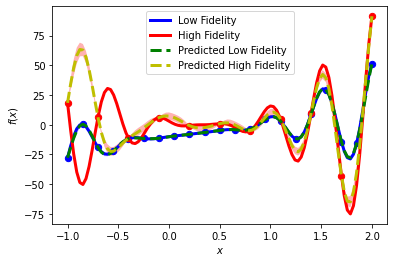

In [3]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import emukit
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

np.random.seed(24)
################################################################################
# Expensive Function
def fe(x):
    return (6.0*x-2.)**2*np.sin(12*x-4)
# Cheap Function
def fc(x):
    A = 0.5*np.sin(x); B=10; C=5
    return A*fe(x) + B*(x-0.5) - C
################################################################################

x  = np.linspace(-1,2,100).reshape(-1,1)                   # Some Uniform Test Points
yl = fc(x)
yh = fe(x)

Xl  =   np.linspace(-1,2,21).reshape(-1,1)                 # Low-fidelity Training Data Feature
Xh  =   np.linspace(-1,2,11).reshape(-1,1)                 # High-fidelity Training Data Feature
Yl  =   fc(Xl)                                             # Get Low-fidelity Labels
Yh  =   fe(Xh)                                             # Get High-fidelity Labels

# In emukit you have to structure data in  a certain way that is why you need this extra function
X, Y = convert_xy_lists_to_arrays([Xl, Xh], [Yl, Yh])

kernels_fid = [GPy.kern.RBF(1), GPy.kern.RBF(1)]              # Define kernels
kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels_fid)    # Initialize the overall kernel
model = GPyLinearMultiFidelityModel(X, Y, kernel, n_fidelities=2) # Initialize model
print(model)
model.mixed_noise.Gaussian_noise.fix(0)                    # Fix first fidelity noise
model.mixed_noise.Gaussian_noise_1.fix(0)                  # Fix second fidelity noise
model.multifidelity.rbf.lengthscale.constrain_bounded(0.1,1)
model.multifidelity.rbf_1.lengthscale.constrain_bounded(0.1,1)
# Attach the model to the GPy by means of this thin wrapper
model = GPyMultiOutputWrapper(model, 2, n_optimization_restarts=200)  
# Optimize your model
model.optimize()

# Generate test data. Again it has to be in a certain order and you have to provide this for every fidelity
Xtest = convert_x_list_to_array([x, x])
Xtestl = Xtest[:len(x)]
Xtesth = Xtest[len(x):]

# Get the mean and variance for each level of fidelity
meanl, varl = model.predict(Xtestl)
stdl = np.sqrt(varl)
meanh, varh = model.predict(Xtesth)
stdh = np.sqrt(varh)

# Plot everything training data, prediction, test data, uncertainty bounds +-(2\sigma)
fig, ax = plt.subplots()
ax.fill_between(x.flatten(), (meanl - 1.96*stdl).flatten(), 
                 (meanl + 1.96*stdl).flatten(), facecolor='blue', alpha=0.3)
ax.fill_between(x.flatten(), (meanh - 1.96*stdh).flatten(), 
                 (meanh + 1.96*stdh).flatten(), facecolor='red', alpha=0.3)

ax.plot(x, yl, 'b', linewidth=3)
ax.plot(x, yh, 'r', linewidth=3)
ax.plot(x, meanl, '--', color='g', linewidth=3)
ax.plot(x, meanh, '--', color='y', linewidth=3)
ax.scatter(Xl, Yl, color='b', s=40)
ax.scatter(Xh, Yh, color='r', s=40)
ax.set_ylabel('$f(x)$')
ax.set_xlabel('$x$')
ax.legend(['Low Fidelity', 'High Fidelity', 'Predicted Low Fidelity', 'Predicted High Fidelity'])
